# Codestral Self Correction Agent with Ollama

[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](
https://colab.research.google.com/github/colinmcnamara/austin_langchain/blob/main/labs/LangChain_108/codestral_self_correction_ollama.ipynb)

This notebook adapts the [original notebook](https://colab.research.google.com/drive/12wc4SND1bY52H7A7EJkhgWDwqmWcvy5k?usp=sharing) and featured on this [YouTube video](https://www.youtube.com/watch?v=zXFxmI9f06M) to work with [Ollama](https://ollama.com/) using [OllamaFunctions](https://python.langchain.com/v0.2/docs/integrations/chat/ollama_functions/) module within [langchain-experimental](https://pypi.org/project/langchain-experimental/) package.

## Install python packages

In [1]:
#! pip install -U langchain_community langchain-mistralai langchain langgraph
! pip install -U langchain_community langchain_experimental langchain langgraph httpx

## (Optionally) Setup environment variables for LangSmith tracing

In [2]:
import os
# os.environ['MISTRAL_API_KEY'] = 'xxx'

# Uncomment below for LangSmith tracing and include your LANGCHAIN_API_KEY.
# os.environ['LANGCHAIN_TRACING_V2'] = 'true'
# os.environ['LANGCHAIN_ENDPOINT'] = 'https://api.smith.langchain.com'
# os.environ['LANGCHAIN_API_KEY'] = "xxx"
os.environ["LANGCHAIN_PROJECT"] = "Mistral-code-gen-testing"

## Install and run Ollama

In [ ]:
%%capture
%%bash
curl -fsSL https://ollama.com/install.sh | sh

### Start Ollama

In [ ]:
%%bash --bg
ollama serve &> ollama.log 2>&1

Wait for Ollama service to be ready

In [ ]:
!until ollama list; do echo waiting for ollama; sleep 5; done

### Download Codestral model for Ollama

In [ ]:
%%bash --bg
ollama pull codestral >> codestral.log 2>&1

Wait for the model to be downloaded and primed. This may take a couple of minutes.

In [ ]:
!echo waiting for codestral
!until ollama list | grep codestral; do sleep 5; done
!echo priming ollama for codestral


In [ ]:
%%capture
%%bash
ollama run codestral "How to print hello world in python?" > sample.md

In [ ]:
%%bash
cat sample.md
echo
echo codestral should be ready

## Setup and test Codestral using OllamaFunctions

In [3]:
# Select LLM
#from langchain_mistralai import ChatMistralAI
from langchain_experimental.llms.ollama_functions import OllamaFunctions
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.pydantic_v1 import BaseModel, Field

# mistral_model = "codestral-latest"
mistral_model = "codestral:latest"
llm = OllamaFunctions(model=mistral_model, temperature=0)

# Prompt
code_gen_prompt_claude = ChatPromptTemplate.from_messages(
    [
        (
            "system",
            """You are a coding assistant. Ensure any code you provide can be executed with all required imports and variables \n
            defined. Structure your answer: 1) a prefix describing the code solution, 2) the imports, 3) the functioning code block.
            \n Here is the user question:""",
        ),
        ("placeholder", "{messages}"),
    ]
)

# Data model
class code(BaseModel):
    """Code output"""

    prefix: str = Field(description="Description of the problem and approach")
    imports: str = Field(description="Code block import statements")
    code: str = Field(description="Code block not including import statements")
    description = "Schema for code solutions to questions about LCEL."

# LLM
code_gen_chain = llm.with_structured_output(code, include_raw=False)

# Test
question = "Write a function for fibonacci."
messages = [("user", question)]
result = code_gen_chain.invoke(messages)
result

code(prefix="To write a function for calculating Fibonacci numbers, we can use recursion or iteration. Here, I'll use the iterative approach as it is more efficient.", imports='', code='def fibonacci(n):\n  if n <= 0:\n    return "Input should be a positive integer"\n  elif n == 1:\n    return 0\n  elif n == 2:\n    return 1\n  else:\n    a, b = 0, 1\n    for _ in range(2, n):\n      a, b = b, a + b\n    return b', description='Schema for code solutions to questions about LCEL.')

## Build Codestral Agent using LangGraph

### Agent State

In [4]:
from typing import Annotated
from typing import Dict, TypedDict, List
from langgraph.graph.message import AnyMessage, add_messages

class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        error : Binary flag for control flow to indicate whether test error was tripped
        messages : With user question, error messages, reasoning
        generation : Code solution
        iterations : Number of tries
    """

    error: str
    messages: Annotated[list[AnyMessage], add_messages]
    generation: str
    iterations: int

### Agent Nodes and other related code

In [5]:
from operator import itemgetter
from langchain_core.pydantic_v1 import BaseModel, Field
from langchain_core.runnables import RunnablePassthrough
from langchain_core.prompts import PromptTemplate

### Parameters
max_iterations = 3

### Nodes
def generate(state: GraphState):
    """
    Generate a code solution

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation
    """

    print("---GENERATING CODE SOLUTION---")

    # State
    messages = state["messages"]
    iterations = state["iterations"]
    error = state["error"]

    # Solution
    code_solution = code_gen_chain.invoke(messages)
    messages += [
        (
            "assistant",
            f"Here is my attempt to solve the problem: {code_solution.prefix} \n Imports: {code_solution.imports} \n Code: {code_solution.code}",
        )
    ]

    # Increment
    iterations = iterations + 1
    return {"generation": code_solution, "messages": messages, "iterations": iterations}

def code_check(state: GraphState):
    """
    Check code

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, error
    """

    print("---CHECKING CODE---")

    # State
    messages = state["messages"]
    code_solution = state["generation"]
    iterations = state["iterations"]

    # Get solution components
    prefix = code_solution.prefix
    imports = code_solution.imports
    code = code_solution.code

    # Check imports
    try:
        exec(imports)
    except Exception as e:
        print("---CODE IMPORT CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the import test. Here is the error: {e}. Reflect on this error and your prior attempt to solve the problem. (1) State what you think went wrong with the prior solution and (2) try to solve this problem again. Return the FULL SOLUTION. Use the code tool to structure the output with a prefix, imports, and code block:")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # Check execution
    try:
        combined_code = f"{imports}\n{code}"
        # Use a shared scope for exec
        global_scope = {}
        exec(combined_code, global_scope)
    except Exception as e:
        print("---CODE BLOCK CHECK: FAILED---")
        error_message = [("user", f"Your solution failed the code execution test: {e}) Reflect on this error and your prior attempt to solve the problem. (1) State what you think went wrong with the prior solution and (2) try to solve this problem again. Return the FULL SOLUTION. Use the code tool to structure the output with a prefix, imports, and code block:")]
        messages += error_message
        return {
            "generation": code_solution,
            "messages": messages,
            "iterations": iterations,
            "error": "yes",
        }

    # No errors
    print("---NO CODE TEST FAILURES---")
    return {
        "generation": code_solution,
        "messages": messages,
        "iterations": iterations,
        "error": "no",
    }

### Conditional edges

def decide_to_finish(state: GraphState):
    """
    Determines whether to finish.

    Args:
        state (dict): The current graph state

    Returns:
        str: Next node to call
    """
    error = state["error"]
    iterations = state["iterations"]

    if error == "no" or iterations == max_iterations:
        print("---DECISION: FINISH---")
        return "end"
    else:
        print("---DECISION: RE-TRY SOLUTION---")
        return "generate"

### Utilities

import uuid

def _print_event(event: dict, _printed: set, max_length=1500):
    current_state = event.get("dialog_state")
    if current_state:
        print(f"Currently in: ", current_state[-1])
    message = event.get("messages")
    if message:
        if isinstance(message, list):
            message = message[-1]
        if message.id not in _printed:
            msg_repr = message.pretty_repr(html=True)
            if len(msg_repr) > max_length:
                msg_repr = msg_repr[:max_length] + " ... (truncated)"
            print(msg_repr)
            _printed.add(message.id)

### Agent Graph

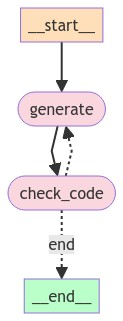

In [6]:
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.graph import END, StateGraph

builder = StateGraph(GraphState)

# Define the nodes
builder.add_node("generate", generate)  # generation solution
builder.add_node("check_code", code_check)  # check code

# Build graph
builder.set_entry_point("generate")
builder.add_edge("generate", "check_code")
builder.add_conditional_edges(
    "check_code",
    decide_to_finish,
    {
        "end": END,
        "generate": "generate",
    },
)

memory = SqliteSaver.from_conn_string(":memory:")
graph = builder.compile(checkpointer=memory)

from IPython.display import Image, display

try:
    display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
except:
    pass

### Test Codestral Self Correction Agent

In [7]:
import uuid
_printed = set()
thread_id = str(uuid.uuid4())
config = {
    "configurable": {
        # Checkpoints are accessed by thread_id
        "thread_id": thread_id,
    }
}

question = "Write a Python program that prints 'Hello, World!' to the console."
events = graph.stream(
    {"messages": [("user", question)], "iterations": 0}, config, stream_mode="values"
)
for event in events:
    _print_event(event, _printed)

event['generation']

================================ Human Message =================================

Write a Python program that prints 'Hello, World!' to the console.
---GENERATING CODE SOLUTION---
================================== Ai Message ==================================

Here is my attempt to solve the problem: To print 'Hello, World!' to the console in Python, we can simply use the print function. 
 Imports:  
 Code: print('Hello, World!')
---CHECKING CODE---
Hello, World!
---NO CODE TEST FAILURES---
---DECISION: FINISH---


code(prefix="To print 'Hello, World!' to the console in Python, we can simply use the print function.", imports='', code="print('Hello, World!')", description='Schema for code solutions to questions about LCEL.')

### LangSmith trace of a single run

https://smith.langchain.com/public/92073ab4-c7ba-41f2-b918-76232bf1edc9/r